In [30]:
import numpy as np
import cv2
from extract_bottleneck_features import *

from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.resnet50 import preprocess_input
from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.metrics import roc_curve

import numpy as np
from glob import glob

%matplotlib inline
ResNet50_model = ResNet50(weights='imagenet') # define ResNet50 model

### Obtain Bottleneck Features

In [2]:
bottleneck_features = np.load('./data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (OPTIONAL) Implement Model Architecture

In [3]:
### TODO: Define your architecture.
# Xception_model = Sequential()
# Xception_model.add(Conv2D(filters = 16, kernel_size = 3, strides = 2, padding = 'valid', 
#                           activation = 'linear', input_shape = train_Xception.shape[1:]))
# Xception_model.add(LeakyReLU(alpha = 0.75))
# Xception_model.add(Dropout(0.5))
# Xception_model.add(GlobalAveragePooling2D(data_format='channels_last'))
# Xception_model.add(Dense(133, activation = 'softmax'))

# Xception_model.summary()

### OPTIONAL Compile the Model

In [4]:
# compile the model
# Xception_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',  metrics=['accuracy'])

### OPTIONAL Train it

In [5]:
# checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.Xception.hdf5', verbose = 1, save_best_only = True)
# Xception_model.fit(train_Xception, train_targets, validation_data = (valid_Xception, valid_targets),
#                    batch_size = 20, callbacks = [checkpointer], verbose = 1, epochs = 50, )

### Load the model with the best Validation Loss

In [6]:
### TODO: Load the model weights with the best validation loss.
Xception_model = Sequential()
Xception_model.add(Conv2D(filters = 16, kernel_size = 3, strides = 2, padding = 'valid', 
                          activation = 'linear', input_shape = train_Xception.shape[1:]))
Xception_model.add(LeakyReLU(alpha = 0.75))
Xception_model.add(Dropout(0.5))
Xception_model.add(GlobalAveragePooling2D(data_format='channels_last'))
Xception_model.add(Dense(133, activation = 'softmax'))

Xception_model.summary()

Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 16)          294928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 3, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 16)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               2261      
Total params: 297,189
Trainable params: 297,189
Non-trainable params: 0
_________________________________________________________________


### OPTIONAL Test it

In [7]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('./data/dog_images/train')
valid_files, valid_targets = load_dataset('./data/dog_images/valid')
test_files, test_targets = load_dataset('./data/dog_images/test')

In [8]:
Xception_predictions = [np.argmax(Xception_model.predict(
    np.expand_dims(feature, axis=0))) for feature in test_Xception]

test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(
    test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.4593%


In [ ]:
# Xception_model.fit(train_Xception, train_targets, validation_data = (valid_Xception, valid_targets),
#                    batch_size = 20, callbacks = [checkpointer], verbose = 1, epochs = 50, )

# y_pred_keras = keras_model.predict(X_test).ravel()
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

# X_test = np.expand_dims(feature, axis=0)
# y_test = 
# y_pred_keras = 
y_pred_keras = keras_model.predict(Xception_predictions).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Xception_predictions)

### Human Face detector

In [9]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

### Predict the dog breed using the model

In [10]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [11]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [12]:
# def extract_Xception(tensor):
#     from keras.applications.xception import Xception, preprocess_input
#     return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def Xceptional_breed(path):
    bottleneck_feature = extract_Xception(path_to_tensor(path)) #get bottleneck features
    predicted_vector = Xception_model.predict(bottleneck_feature) #get predicted vector
    return dog_names[np.argmax(predicted_vector)] #return dog breed 

In [26]:
def looks_like(path):
    img = cv2.imread(path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imread()
    if dog_detector(path):
        plt.imshow(cv_rgb)
        plt.show()
        print('The dog most likely to be in this picture is a %s' %Xceptional_breed(path)[8:])
    elif (face_detector(path)):
        plt.imshow(cv_rgb)
        plt.show()
        Xceptional_breed(path)
        print('You look most like a %s' %Xceptional_breed(path)[8:])
    else:
        plt.imshow(cv_rgb)
        plt.show()
        print('I do not see a dog or a human in this picture.')

In [14]:
def looks_like_noVerify(path):
    img = cv2.imread(path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    Xceptional_breed(path)
    print('You look most like a %s' %Xceptional_breed(path)[8:])

In [15]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [16]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [17]:
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [18]:
# Import the list of dog names
dog_names = [item[20:-1] for item in sorted(glob("./data/dog_images/train/*/"))]

### Run it on your pretty pictures

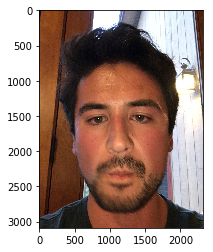

You look most like a American_foxhound


In [33]:
looks_like('Uploaded Images/Dan.jpeg')

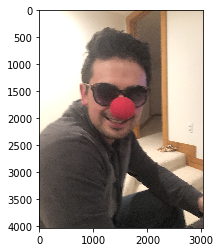

You look most like a Australian_shepherd


In [36]:
looks_like('Uploaded Images/Dan/clown.jpeg')

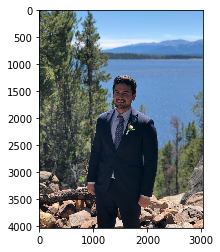

You look most like a American_staffordshire_terrier


In [38]:
looks_like('Uploaded Images/Dan/wedding.jpeg')

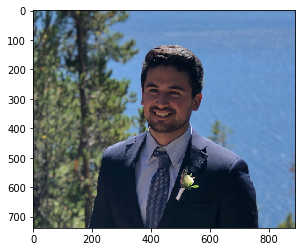

You look most like a Bloodhound


In [41]:
looks_like('Uploaded Images/Dan/wedding2.jpeg')

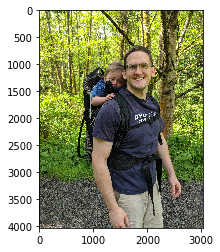

You look most like a Cardigan_welsh_corgi


In [44]:
looks_like('Uploaded Images/Troy/hiking.jpg')

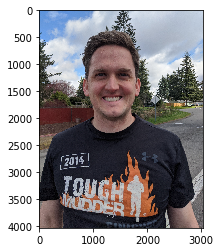

You look most like a Norfolk_terrier


In [45]:
looks_like('Uploaded Images/Troy/mudder.jpg')

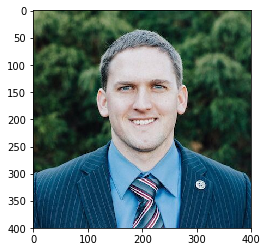

You look most like a Bearded_collie


In [46]:
looks_like('Uploaded Images/Troy/Troy.jpg')

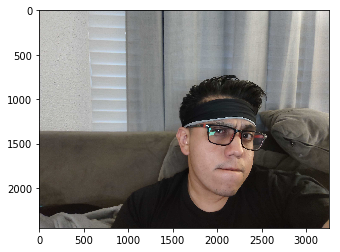

You look most like a Cardigan_welsh_corgi


In [61]:
looks_like_noVerify('Uploaded Images/Ricardo/Ricardo1.jpg')

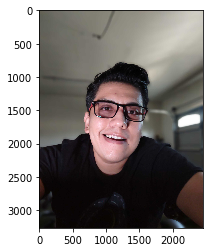

You look most like a Basset_hound


In [49]:
looks_like('Uploaded Images/Ricardo/Ricardo2.jpg')

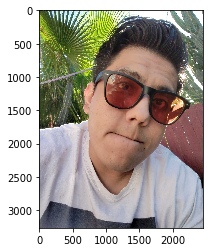

You look most like a Cardigan_welsh_corgi


In [62]:
looks_like_noVerify('Uploaded Images/Ricardo/Ricardo3.jpg')

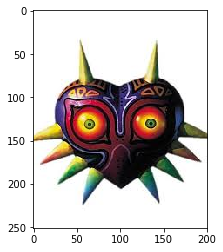

You look most like a American_eskimo_dog


In [60]:
looks_like_noVerify('Uploaded Images/majora.jpeg')

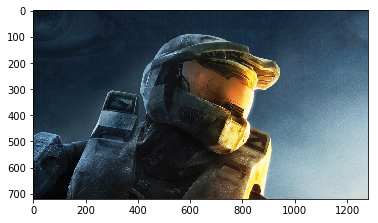

You look most like a Border_terrier


In [63]:
looks_like_noVerify('Uploaded Images/NotFaces/MisterChef.jpg')

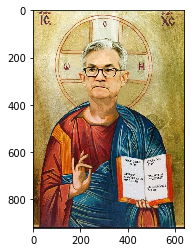

You look most like a Poodle


In [19]:
looks_like('Uploaded Images/stJPOW.jpg')

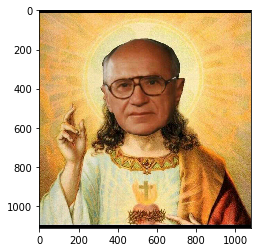

You look most like a Chinese_crested


In [20]:
looks_like('Uploaded Images/Milton.jpg')

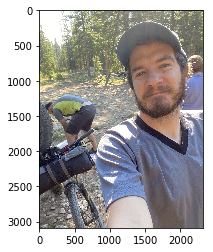

You look most like a Papillon


In [22]:
looks_like_noVerify('Uploaded Images/Nick/Nick.jpg')

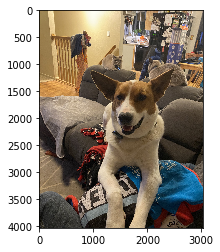

The dog most likely to be in this picture is a Basenji


In [27]:
looks_like('Uploaded Images/Dogs/toby.jpg')

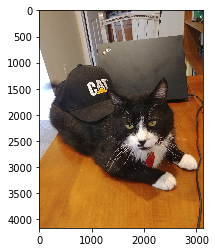

You look most like a Nova_scotia_duck_tolling_retriever


In [24]:
looks_like_noVerify('Uploaded Images/Dogs/winston.jpg')

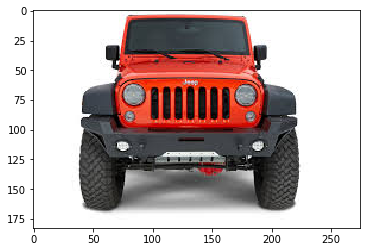

You look most like a German_shorthaired_pointer


In [28]:
looks_like_noVerify('Uploaded Images/NotFaces/jeep.jpg')

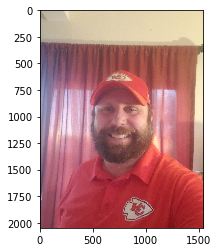

You look most like a Norwich_terrier


In [29]:
looks_like('Uploaded Images/DrWagner.jpeg')